# SINDy SR3 with constraints: 2D Duffing oscillator

This notebook performs SINDy SR3 with linear constraints on example data from a 2D Duffing system. This system is Hamiltonian, and the enforced constraints require that equations are gradients of a potential function.

In [1]:
import sys
import numpy as np
from scipy.integrate import odeint
from sklearn.metrics import r2_score

import pysindy as ps
sys.path.insert(0, '..')
from utils import *
from sr3_enhanced import SR3Enhanced

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
def simulate_2d_duffing_from_model(model, x0, t):
    def rhs(x, t):
        pred = model.predict(x[np.newaxis, 0:2])[0]
        return [x[2], x[3], pred[0], pred[1]]

    return odeint(rhs, x0, t)

def simulate_multi_trajectory(model, x, t):
    x_sim = []
    for i in range(len(x)):
        x_sim.append(simulate_2d_duffing_from_model(model, x[i][0], t))
    return x_sim

def score_multi_trajectory(x_true, x_sim):
    d = x_true[0].shape[-1]
    return r2_score(np.array(x_true).reshape((-1,d)), np.array(x_sim).reshape((-1,d)))

## Generate training data

In [3]:
np.random.seed(1)

# time grid set up
ts = 0.0
te = 10
dt = .01
t = np.arange(ts,te,dt)

omega = -1
alpha = 1

# ode set up
f  = lambda x, t : [x[2],
                    x[3],
                    -omega*x[0] - alpha*(x[0]**3 + x[0]*x[1]**2),
                    -omega*x[1] - alpha*(x[0]**2*x[1] + x[1]**3)]

# generate training data
n_trajectories = 20
x0s = np.zeros((n_trajectories,4))
x0s[:,0:2] = 2*np.pi*(np.random.rand(n_trajectories,2)-.5)
x0s[:,2:] = 2*np.pi*(np.random.rand(n_trajectories,2)-.5)
x = []
for i in range(n_trajectories):
    x.append(odeint(f, x0s[i], t))
x_noisy = add_noise(x, .01)

Text(0, 0.5, 'y')

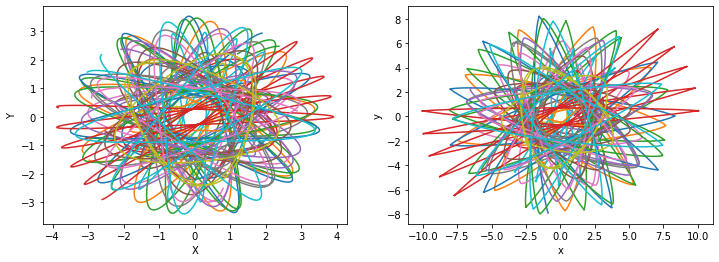

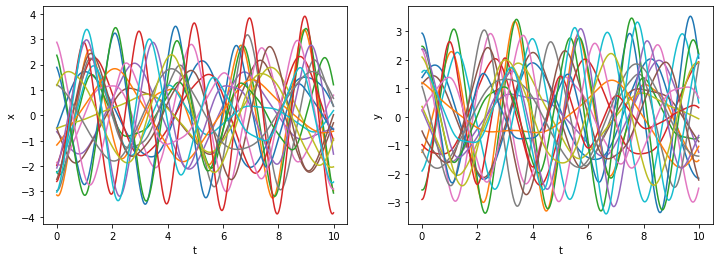

In [4]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
for i in range(n_trajectories):
    plt.plot(x[i][:,0], x[i][:,1])
plt.xlabel('X')
plt.ylabel('Y')
    
plt.subplot(1,2,2)
for i in range(n_trajectories):
    plt.plot(x[i][:,2], x[i][:,3])
plt.xlabel('x')
plt.ylabel('y')
    
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
for i in range(n_trajectories):
    plt.plot(t, x[i][:,0])
plt.xlabel('t')
plt.ylabel('x')
    
plt.subplot(1,2,2)
for i in range(n_trajectories):
    plt.plot(t, x[i][:,1])
plt.xlabel('t')
plt.ylabel('y')

## Set up the 2D gradient constraint matrix

In [5]:
n_constraints = 6
l = 10
gradient_constraint = np.zeros((n_constraints,2*l))
gradient_constraint[0,3] = 1
gradient_constraint[0,4] = -1
gradient_constraint[1,7] = 2
gradient_constraint[1,8] = -1
gradient_constraint[2,9] = 1
gradient_constraint[2,10] = -2
gradient_constraint[3,13] = 3
gradient_constraint[3,14] = -1
gradient_constraint[4,15] = 1
gradient_constraint[4,16] = -1
gradient_constraint[5,17] = 1
gradient_constraint[5,18] = -3

In [6]:
threshold = 0.1
nu = 1
library = ps.PolynomialLibrary(degree=3)

## Fit both unconstrained and constrained models at different noise levels

In [7]:
noise_levels = [0,.01,.05,0.1]

coefs_unconstrained = []
coefs_constrained = []
models_unconstrained = []
models_constrained = []
scores = np.zeros((2,len(noise_levels)))

for i,eps in enumerate(noise_levels):
    print('\nnoise level: %f' % eps)
    x_noisy = add_noise(x, eps)
    diff = ps.FiniteDifference()
    x_dot = []
    for j in range(n_trajectories):
        x_dot.append(diff._differentiate(x_noisy[j], t))

    print('unconstrained:')
    x_p_only = []
    x_dot_q_only = []
    for j in range(n_trajectories):
        x_p_only.append(x_noisy[j][:,0:2])
        x_dot_q_only.append(x_dot[j][:,2:])

    optimizer_sr3 = ps.SR3(threshold=threshold, nu=nu)
    model = ps.SINDy(optimizer=optimizer_sr3,
                      feature_library=library, feature_names=['x','y','z'])
    model.fit(x_p_only, t=dt, x_dot=x_dot_q_only, multiple_trajectories=True)
    coefs_unconstrained.append(model.coefficients())
    model.print(lhs=["X'","Y'"])
    models_unconstrained.append(model)
    x_sim = simulate_multi_trajectory(model, x_noisy, t)
    scores[0,i] = score_multi_trajectory(x, x_sim)
    print('score: %f' % scores[0,i])
    
    print('constrained:')
    optimizer_sr3 = SR3Enhanced(threshold=threshold, nu=nu,
                        constraint_lhs=gradient_constraint, constraint_rhs=np.zeros((n_constraints)))
    model = ps.SINDy(optimizer=optimizer_sr3,
                      feature_library=library, feature_names=['x','y','z'])
    model.fit(x_p_only, t=dt, x_dot=x_dot_q_only, multiple_trajectories=True, unbias=False)
    coefs_constrained.append(model.coefficients())
    model.print(lhs=["X'","Y'"])
    models_constrained.append(model)
    x_sim = simulate_multi_trajectory(model, x_noisy, t)
    scores[1,i] = score_multi_trajectory(x, x_sim)
    print('score: %f' % scores[1,i])


noise level: 0.000000
unconstrained:
X' = 0.996 x + -0.999 x^3 + -0.999 x y^2
Y' = 0.996 y + -0.999 x^2 y + -0.999 y^3
score: 0.999995
constrained:
X' = 0.996 x + -0.999 x^3 + -0.999 x y^2
Y' = 0.996 y + -0.999 x^2 y + -0.999 y^3
score: 0.999995

noise level: 0.010000
unconstrained:
X' = 0.992 x + -0.999 x^3 + -0.998 x y^2
Y' = 0.992 y + -0.998 x^2 y + -0.999 y^3
score: 0.996534
constrained:
X' = 0.993 x + -0.999 x^3 + -0.998 x y^2
Y' = 0.993 y + -0.998 x^2 y + -0.999 y^3
score: 0.996543

noise level: 0.050000
unconstrained:
X' = 0.989 x + -0.997 x^3 + -0.993 x y^2
Y' = 0.971 y + -0.999 x^2 y + -0.991 y^3
score: 0.954052
constrained:
X' = 0.994 x + -0.997 x^3 + -0.996 x y^2
Y' = 0.963 y + -0.996 x^2 y + -0.991 y^3
score: 0.953296

noise level: 0.100000
unconstrained:
X' = 0.880 x + -0.976 x^3 + -0.965 x y^2
Y' = 0.857 y + -0.969 x^2 y + -0.964 y^3
score: 0.797164
constrained:
X' = 0.874 x + -0.974 x^3 + -0.964 x y^2
Y' = 0.846 y + -0.964 x^2 y + -0.963 y^3
score: 0.796345


## Plot simulations on single trajectory

(-4.0, 4.0, -4.0, 4.0)

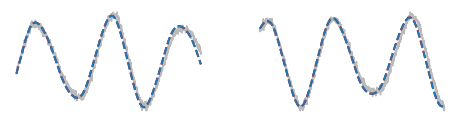

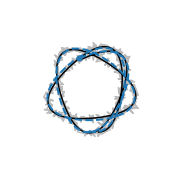

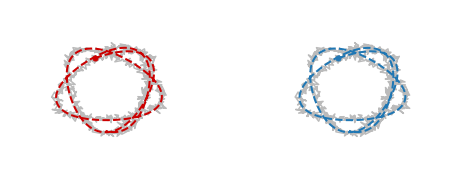

In [8]:
x_sim1 = simulate_multi_trajectory(models_unconstrained[-1], x_noisy, t)
x_sim2 = simulate_multi_trajectory(models_constrained[-1], x_noisy, t)

idx=0
plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
plt.plot(x_noisy[idx][:,0], color='#bbbbbb')
plt.plot(x_sim1[idx][:,0], '--', color='#cc0000', linewidth=2)
plt.plot(x_sim2[idx][:,0], '--', linewidth=2)
plt.axis('off')
plt.subplot(1,2,2)
plt.plot(x_noisy[idx][:,1], color='#bbbbbb')
plt.plot(x_sim1[idx][:,1], '--', color='#cc0000', linewidth=2)
plt.plot(x_sim2[idx][:,1], '--', linewidth=2)
plt.axis('off')
# plt.savefig('sim_duffing_time.eps', dpi=600)

lims = [-4,4]
plt.figure(figsize=(3,3))
plt.plot(x_noisy[idx][:,0], x_noisy[idx][:,1], color='#bbbbbb')
plt.plot(x[idx][:,0], x[idx][:,1], color='k')
plt.plot(x_sim2[idx][:,0], x_sim2[idx][:,1], '--', linewidth=2)
plt.plot(x_noisy[idx][0,0], x_noisy[idx][0,1], '.', color='#2478B4', markersize=10)
plt.xlim(lims)
plt.ylim(lims)
plt.axis('off')
# plt.savefig('sim_duffing_xy.pdf', dpi=600)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(x_noisy[idx][:,0], x_noisy[idx][:,1], color='#bbbbbb')
plt.plot(x_sim1[idx][:,0], x_sim1[idx][:,1], '--', color='#cc0000', linewidth=2)
plt.plot(x_noisy[idx][0,0], x_noisy[idx][0,1], '.', color='#cc0000', markersize=10)
plt.xlim(lims)
plt.ylim(lims)
plt.axis('off')
plt.subplot(1,2,2)
plt.plot(x_noisy[idx][:,0], x_noisy[idx][:,1], color='#bbbbbb')
plt.plot(x_sim2[idx][:,0], x_sim2[idx][:,1], '--', linewidth=2)
plt.plot(x_noisy[idx][0,0], x_noisy[idx][0,1], '.', color='#2478B4', markersize=10)
plt.xlim(lims)
plt.ylim(lims)
plt.axis('off')

## Assess simulation performance on test data

In [9]:
# generate test data
n_trajectories = 50
x0s = np.zeros((n_trajectories,4))
x0s[:,0:2] = 2*np.pi*(np.random.rand(n_trajectories,2)-.5)
x0s[:,2:] = 2*np.pi*(np.random.rand(n_trajectories,2)-.5)
x_test = []
for i in range(n_trajectories):
    x_test.append(odeint(f, x0s[i], t))

scores_unconstrained = []
for model in models_unconstrained:
    sims = simulate_multi_trajectory(model, x_test, t)
    scores_unconstrained.append(score_multi_trajectory(x_test, sims))
    
scores_constrained = []
for model in models_constrained:
    sims = simulate_multi_trajectory(model, x_test, t)
    scores_constrained.append(score_multi_trajectory(x_test, sims))

In [10]:
print('R-squared scores')
for i,noise_level in enumerate(noise_levels):
    print('noise level %f: unconstrained score %f, constrained score %f' % (noise_level,
                                                                            scores_unconstrained[i],
                                                                            scores_constrained[i]))

R-squared scores
noise level 0.000000: unconstrained score 0.999994, constrained score 0.999994
noise level 0.010000: unconstrained score 0.999971, constrained score 0.999974
noise level 0.050000: unconstrained score 0.998681, constrained score 0.999238
noise level 0.100000: unconstrained score 0.989233, constrained score 0.988012
